# Surface Defects Classification

The project work is inspired by **Industry 4.0** concept. One of the possible AI applications in industry is **Computer Vision** (CV). CV is especially useful at defect detection and classification, that can help at early diagnostics of complicated and expensive machinery. 

In the current work _the hot-rolled steel strip surface images are analyzed to detect and classify six typical defect categories_ : crazing (Cr), inclusion (In),  patches (Pa), pitted surface (PS), rolled-in scale (RS)  and scratches (Sc).

Within the project, only one of many possible models and their architectures is explored, specifically **Convolutional Neural Network** (CNN). This type of Neural Networks proved its efficiency for CV problem solving. There exists several top state-of-the-art CNN architectures; for the current project, `ResNet101` with, as its name suggests, 101 layers to classify the defects. 

As a data source, [NEU surface defect database](http://faculty.neu.edu.cn/yunhyan/NEU_surface_defect_database.html) is taken.

1. [Data Exploration](#explore)
2. [Data Preparation](#prepare)
3. [Model Building](#build)
4. [Model Training](#train)
5. [Model Evaluation](#evaluate)
6. [Conclusion](#conclude)

In [1]:
# import libraries 

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.metrics import confusion_matrix, classification_report
from random import randint
from PIL import Image, ImageDraw

%matplotlib inline

from tensorflow.keras import applications, Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# check the GPU availability

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# configure the GPU

if tf.config.list_physical_devices('GPU'):
    device = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(device[0], enable=True)
    tf.config.experimental.set_virtual_device_configuration(device[0],
                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8000)])

<a id="explore"></a>
## Data Exploration

6 classes:
['crazing', 'inclusion', 'patches', 'pitted', 'rolled', 'scratches']


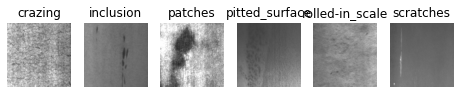

In [4]:
# get the class names

data_folder = 'IMAGES'
classes = os.listdir(data_folder)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# show the first image in each folder
fig = plt.figure(figsize=(8, 10))
i = 0
for sub_dir in os.listdir(data_folder):
    i += 1
    img_file = os.listdir(os.path.join(data_folder,sub_dir))[0]
    img_path = os.path.join(data_folder, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a = fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file.replace('_1.jpg',''))
plt.show()

<a id="prepare"></a>
## Data Preparation

Before the model is trained, the data should be prepared. For this reason, the feature values are divided by 255 to normalize them as floating point values between 0 and 1, and the data is splitted, so that 70% of it can be used to train the model, and 30% is held back to validate it. When loading the data, the data generator will assing 'hot-encoded' numeric labels to indicate which class each image belongs to based on the subfolders in which the data is stored. In this case, there are six subfolders - *crazing*, *inclusion*, *patches*, *pitted*, *rolled* and *scratches* so the labels will consist of six *0* or *1* values indicating which of these classes is associated with the image - for example the label [0 1 0 0 0 0] indicates that the image belongs to the second class (*inclusion*).

In [5]:
# use ImageDataGenerator loader

from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (200, 200)
batch_size = 20

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1/255.0, # normalize pixel values
                             rotation_range=30, # add rotated images 
                             vertical_flip=True, # vertically flip images
                             validation_split=0.3,  # hold back 30% of the images for validation
                             preprocessing_function = None)

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print('Data generators ready')

Getting Data...
Preparing training dataset...
Found 1260 images belonging to 6 classes.
Preparing validation dataset...
Found 540 images belonging to 6 classes.
Data generators ready


<a id="build"></a>
##  Model Building

To classify the defects, the **ResNet101** CNN architecture is used. For this reason, the **transfer learning** technique is used to import the state-of-the-art CNN model architecture, and then add the top layers.

In [6]:
# import ResNet101 model

base_model = keras.applications.resnet.ResNet101(include_top=False, input_shape=(200,200,3))
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [7]:
# add top layers

model = Sequential([
    base_model,
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(classnames), activation='linear', kernel_regularizer = l2(0.01))
])

# compile the model
model.compile(loss='hinge',
              optimizer='adadelta',
              metrics=['accuracy'])

# output the full model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                3211296   
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 45,869,670
Trainable params: 45,764,326
Non-trainable params: 105,344
_________________________________________________________________


<a id="train"></a>
## Model Training

The model is trained over 100 epochs, making use of both training and validation sets. 

In [8]:
%%time

# train the model over 100 epochs
num_epochs = 100
history = model.fit(train_generator, steps_per_epoch = train_generator.samples // batch_size, 
                    validation_data = validation_generator, validation_steps = validation_generator.samples // batch_size,
                    epochs = num_epochs)

Epoch 1/100
63/63 [==============================] - 125s 2s/step - loss: 1.3713 - accuracy: 0.1824 - val_loss: 1.8199 - val_accuracy: 0.1667
Epoch 2/100
63/63 [==============================] - 105s 2s/step - loss: 1.0294 - accuracy: 0.1926 - val_loss: 4.5721 - val_accuracy: 0.1778
Epoch 3/100
63/63 [==============================] - 105s 2s/step - loss: 0.8874 - accuracy: 0.2681 - val_loss: 8.4937 - val_accuracy: 0.1648
Epoch 4/100
63/63 [==============================] - 105s 2s/step - loss: 0.7937 - accuracy: 0.3063 - val_loss: 7.7083 - val_accuracy: 0.1204
Epoch 5/100
63/63 [==============================] - 106s 2s/step - loss: 0.7378 - accuracy: 0.3276 - val_loss: 8.4183 - val_accuracy: 0.1130
Epoch 6/100
63/63 [==============================] - 107s 2s/step - loss: 0.6985 - accuracy: 0.3811 - val_loss: 8.8623 - val_accuracy: 0.1148
Epoch 7/100
63/63 [==============================] - 109s 2s/step - loss: 0.6635 - accuracy: 0.3982 - val_loss: 9.0030 - val_accuracy: 0.1185
Epoch 

<a id="evaluate"></a>
## Model Evaluation

For model evaluation, the **loss** and **accuracy** history for both **training** and **validation** sets is plotted.

The classification accuracy is analyzed by building a **confusion matrix**, that allows to see, what defects are classified with the highest and lowest accuracy, and printing a **classification report** to check the **precision, recall and f1-score**, combining this two metrics. All these metrics can be found in the `scikit-learn` library.

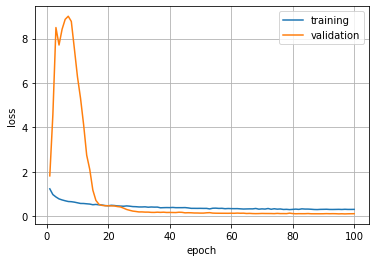

In [9]:
# plot the loss and validation loss

epoch_nums = range(1,num_epochs+1)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.grid()
plt.show()

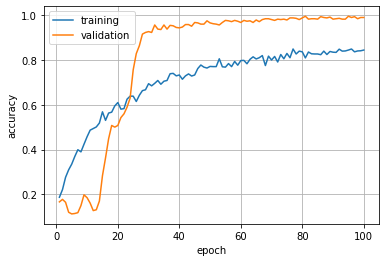

In [10]:
# plot the accuracy and validation accuracy

epoch_nums = range(1,num_epochs+1)
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
plt.plot(epoch_nums, training_acc)
plt.plot(epoch_nums, validation_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'], loc='upper left')
plt.grid()
plt.show()

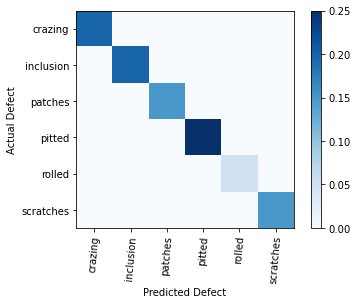

              precision    recall  f1-score   support

     crazing       1.00      1.00      1.00         4
   inclusion       1.00      1.00      1.00         4
     patches       1.00      1.00      1.00         3
      pitted       1.00      1.00      1.00         5
      rolled       1.00      1.00      1.00         1
   scratches       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [13]:
# plot a confusion matrix to gain in-depth performance exploration

# get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# use the model to predict the class
class_probabilities = model.predict(x_test)

# the model returns a probability value for each class
# the one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# the actual labels are hot encoded (e.g. [0 1 0 0 0 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# plot the confusion matrix
cm = confusion_matrix(true_labels, predictions, normalize='all')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel('Predicted Defect')
plt.ylabel('Actual Defect')
plt.show()

# print the classification report
print(classification_report(true_labels, predictions, target_names=classes))

As the training and validation sets do not have many examples (each defect has 300 images, divided into 210 and 90 used for training and validation respectively), the CNN is able to determine the main features of each defect and, thus, have high accuracy.

<a id="conclude"></a>
# Conclusion

As the result of the project,one of possible solutions for the Computer Vision problem of classifying the steel strip surface defects was found. The model performance and the accuracy obtained allow to use CV for such industry applications.  